In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

In [21]:
import tensorflow
from  keras.models import Sequential, Model
from  keras.layers import Input, Dense, LeakyReLU, Activation, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, InputLayer, Flatten, BatchNormalization, Reshape, Lambda

from  keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  keras.applications.vgg16 import VGG16, preprocess_input
#from  keras.applications import ResNet152V2,ResNet101V2,ResNet50V2 
#from  keras.applications.resnet_v2 import preprocess_input 

from  keras.optimizers import RMSprop, Adam
from  keras.preprocessing.image import load_img, ImageDataGenerator
from  keras.utils import multi_gpu_model
from IPython.display import Image 

import keras_metrics
import pandas
import ast
import numpy as np
import matplotlib.patches as patches 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw,ImageFont

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras.backend as K
import numpy as np
import random

In [4]:
BATCH_SIZE = 16
IMG_SIZE = 224

In [6]:
train_df = pandas.read_csv("./dataset/FACE_CLASSIFIER/train.csv")
valid_df = pandas.read_csv("./dataset/FACE_CLASSIFIER/val.csv")
test_df = pandas.read_csv("./dataset/FACE_CLASSIFIER/test.csv")

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,)
    #preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory="./",
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory="./",
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 33175 validated image filenames.
Found 3688 validated image filenames.


In [8]:
step_size_train = train_generator.samples/train_generator.batch_size
step_size_valid = valid_generator.samples/valid_generator.batch_size

In [9]:
darknetv1 = Sequential()
darknetv1.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)))
darknetv1.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))
darknetv1.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(GlobalAveragePooling2D())

In [10]:
darknetv1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 192)     768       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 112, 112, 192)    

In [11]:
darknetv1.add(Dense(512, activation = "relu"))
darknetv1.add(Dense(512, activation = "relu"))
darknetv1.add(Dense(1, activation = "sigmoid"))

In [12]:
darknetv1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 192)     768       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 112, 112, 192)    

model = multi_gpu_model(model, gpus=2) #parallelize model

In [13]:
darknetv1.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
darknetv1.evaluate_generator(valid_generator, steps=step_size_valid, verbose = 1)


231/230 [==============================] - 18s 79ms/step


[0.6931463479995728, 0.5]

In [15]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('face_classifier_BN.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min')

history = darknetv1.fit_generator(generator=train_generator, epochs=20, steps_per_epoch=step_size_train, validation_data=valid_generator, validation_steps=step_size_valid, verbose=1, callbacks=[mcp_save, reduce_lr_loss])

Epoch 1/20
2074/2073 [==============================] - 425s 205ms/step - loss: 0.1908 - accuracy: 0.9278 - val_loss: 0.0140 - val_accuracy: 0.9591
Epoch 2/20
2074/2073 [==============================] - 422s 204ms/step - loss: 0.1213 - accuracy: 0.9594 - val_loss: 0.5509 - val_accuracy: 0.9756
Epoch 3/20
2074/2073 [==============================] - 422s 203ms/step - loss: 0.0967 - accuracy: 0.9684 - val_loss: 0.1356 - val_accuracy: 0.9759
Epoch 4/20
2074/2073 [==============================] - 422s 203ms/step - loss: 0.0827 - accuracy: 0.9736 - val_loss: 0.0236 - val_accuracy: 0.9797
Epoch 5/20
2074/2073 [==============================] - 422s 204ms/step - loss: 0.0731 - accuracy: 0.9763 - val_loss: 0.0037 - val_accuracy: 0.9805
Epoch 6/20
2074/2073 [==============================] - 422s 203ms/step - loss: 0.0660 - accuracy: 0.9781 - val_loss: 0.4901 - val_accuracy: 0.9707
Epoch 7/20
2074/2073 [==============================] - 422s 204ms/step - loss: 0.0611 - accuracy: 0.9808 - val_

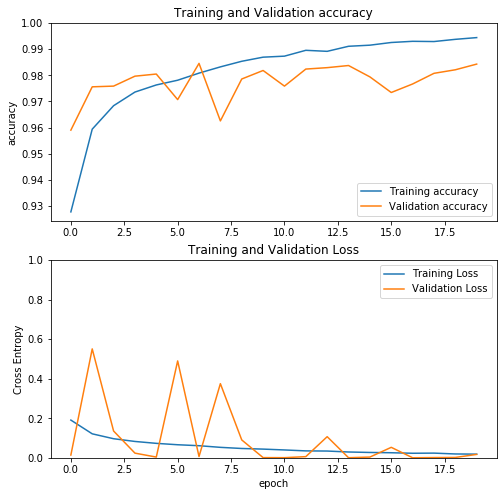

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Loading model

In [17]:
darknetv2 = Sequential()
darknetv2.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)))
darknetv2.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))
darknetv2.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(GlobalAveragePooling2D())

darknetv2.add(Dense(512, activation = "relu"))
darknetv2.add(Dense(512, activation = "relu"))
darknetv2.add(Dense(1, activation = "sigmoid"))

In [18]:
darknetv2.load_weights("face_classifier_BN.h5") 
darknetv2.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="./",
            x_col="image_path",
            y_col="face",
            class_mode="raw",
            shuffle=False,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE)

STEP_SIZE_TEST = test_generator.n / test_generator.batch_size 


#CHANGE PARALLEL MODEL
pred=darknetv2.predict_generator(test_generator,  steps=STEP_SIZE_TEST,  verbose=1)


Found 4099 validated image filenames.
257/256 [==============================] - 18s 71ms/step


In [22]:
img = Image.open(test_generator.filenames[1])
img1 = ImageDraw.Draw(img)
font = ImageFont.truetype("arial.ttf", 50)
# get a drawing context
# draw text, half opacity
img1.text((0,0), str(pred[1]), font = font,fill=(0,0,0,0))
img.save("./dataset/FACE_CLASSIFIER/testlabel3" + ".jpg")
img.show()

In [29]:
count = 0
for el in zip(pred,test_generator.labels,test_generator.filenames):
    count = count +1
    print(count) if count % 1000 == 0 else 0
    if el[1] == 1:
        #print(el)
        img = Image.open(el[2])
        img1 = ImageDraw.Draw(img)
        font = ImageFont.truetype("arial.ttf", 50)
        # get a drawing context
        # draw text, half opacity
        img1.text((0,0), str(el[0]), font = font,fill=(0,0,0,0))
        #img.show() 
        img.save("./dataset/FACE_CLASSIFIER/results/output"+ str(count) + ".jpg")
    elif el[1] == 0:
        print(el[0])
        img = Image.open(el[2])
        img1 = ImageDraw.Draw(img)
        font = ImageFont.truetype("arial.ttf", 50)
        # get a drawing context
        # draw text, half opacity
        img1.text((0,0), str(el[0]), font = font,fill=(0,0,0,0))
        #img.show() 
        img.save("./dataset/FACE_CLASSIFIER/results/output"+ str(count) + ".jpg")

[0.00057933]
[3.5375357e-05]
[0.00069422]
[6.401539e-05]
[0.00041837]
[0.01321837]
[0.00024953]
[0.00054872]
[0.02092779]
[0.00041628]
[8.9854e-05]
[0.00107512]
[0.00021207]
[0.5172687]
[0.49580547]
[0.00570112]
[0.00025004]
[0.00015435]
[5.26309e-05]
[0.00011054]
[8.147955e-05]
[0.00024161]
[7.7068806e-05]
[0.00069657]
[0.00010085]
[0.0002808]
[0.25428247]
[0.00622657]
[0.00054309]
[7.2449446e-05]
[0.12879887]
[0.0002133]
[0.00012726]
[3.0457973e-05]
[0.00087079]
[3.796816e-05]
[0.00012946]
[0.00123641]
[8.684397e-05]
[0.00062549]
[0.00061411]
[0.00140163]
[0.00015038]
[0.00087065]
[0.00012818]
[0.0003171]
[0.00018761]
[0.00031787]
[0.9981358]
[0.0001125]
[0.00081185]
[0.00087303]
[0.00023228]
[0.00031853]
[0.00011906]
[4.4703484e-05]
[7.939339e-05]
[0.00622737]
[0.00250414]
[0.00018671]
[0.00064379]
[0.9759568]
[0.00047895]
[0.8314279]
[0.00019473]
[0.00047177]
[0.00012788]
[0.00069952]
[0.00091562]
[0.0035162]
[8.532405e-05]
[1.564622e-05]
[0.00011119]
[9.807944e-05]
[0.99200755]
[0

TypeError: function takes exactly 1 argument (4 given)